# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

### Init args

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

In [7]:
N = 12*24
sub_t = 300

## One Res Simulation

In [8]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [9]:
mass1 = np.zeros(N)

In [10]:
for n in range(N):
    mass1[n] = np.sum(sim.download(interior_domain_only=True)[0])
    sim.step(sub_t)

## Multi Res Simulation

In [12]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

scale = 2.0

In [11]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)
sim.give_birth(gpu_ctx_refined, loc, scale)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [14]:
mass2 = np.zeros(N)
mass2[0] = np.sum(sim.download(interior_domain_only=True)[0])

In [15]:
for n in range(N):
    mass2[n] = np.sum(sim.download(interior_domain_only=True)[0])
    sim.step(sub_t)

## Mass plot

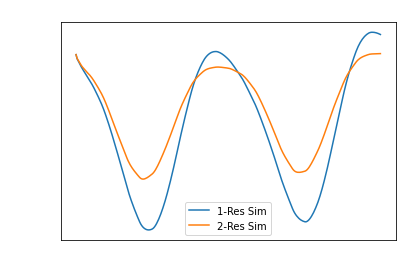

In [20]:
ts = np.arange(N)*sub_t/(12*60)
plt.plot(ts, mass1, label="1-Res Sim")
plt.plot(ts, mass2, label="2-Res Sim")
plt.title("Mass in system")
plt.xlabel("Time [h]")
plt.legend(labelcolor="black")


### Mass breakdown in the projections


Check here:

Coarse grid _--interp-->_ Fine grid _--interp-->_ Coarse grid

In [17]:
from gpuocean.utils import OceanographicUtilities

In [21]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)
sim.give_birth(gpu_ctx_refined, loc, scale)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The bathymetry is only intersection-rescaled and padded in the ghost cells: 
                Please implement a better informed bathymetry refinement! 
                and search for "TODO: If bathymetry changes, this has to be adapted here!" in the source code.


In [24]:
eta_coarse = sim.download()[0][loc[0][0]+2 : loc[1][0]+2, loc[0][1]+2 : loc[1][1]+2]
Bm_coarse = sim.bathymetry.Bm.data.get()[loc[0][0]+2 : loc[1][0]+2, loc[0][1]+2 : loc[1][1]+2]
print("Mass on coarse grid: ", np.sum(eta_coarse+Bm_coarse)*sim.dx*sim.dy)

Mass on coarse grid:  1632466100000.0


In [22]:
child = sim.children[0]
eta_fine = child.download(interior_domain_only=True)[0]
Bm_fine = child.bathymetry.Bm.data.get()[2:-2,2:-2]
print("Mass on fine grid: ", np.sum(eta_fine+Bm_fine)*child.dx*child.dy)

Mass on fine grid:  1633293400000.0


In [23]:
eta2coarse = OceanographicUtilities.rescaleMidpoints(eta_fine, loc[1][1]-loc[0][1], loc[1][0]-loc[0][0])[2]
print("Projected mass on coarse grid: ", np.sum(eta2coarse+Bm_coarse)*sim.dx*sim.dy)

Mass on coarse grid:  1632466205061.2498
